In [1]:
import qtorch
import qtorch.quant
import torch

In [2]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


In [3]:
evaluate_points = torch.linspace(-5, 5, 1000)

In [18]:
number = qtorch.FloatingPoint(8, 0)
quantizer = qtorch.quant.Quantizer(number)
def quantized_sigmoid_mean(x):
    results = []
    for i in range(1000):
        x_hat = quantizer(x)
        results.append(sigmoid(x_hat))
    results = torch.vstack(results)
    return torch.mean(results, dim=0)

In [19]:
q_sigmoids = quantized_sigmoid_mean(evaluate_points)

In [20]:
sigmoids = sigmoid(evaluate_points)

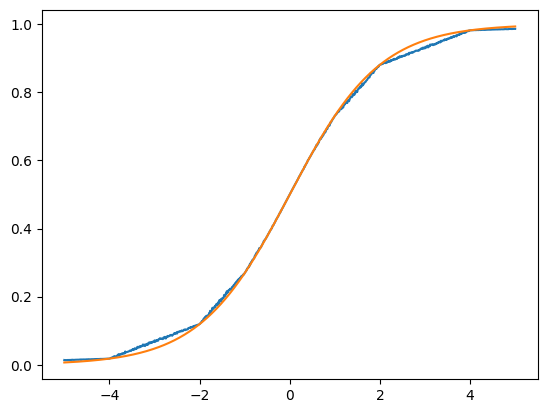

: 

In [21]:
import matplotlib.pyplot as plt
plt.plot(evaluate_points, q_sigmoids, label='quantized sigmoid')
plt.plot(evaluate_points, sigmoids, label='sigmoid')

In [ ]:
number = qtorch.FloatingPoint(8, 2)
quantizer = qtorch.quant.Quantizer(number)

x_hats = []
results = []
for i in range(10000):
    x = torch.tensor([3.23])
    x_hat = quantizer(x)
    x_hats.append(x_hat)
    results.append(sigmoid(x_hat))


In [45]:
mean = torch.mean(torch.stack(results))

In [46]:
mean

tensor(0.9609)

In [47]:
sigmoid(torch.tensor([3.23]))

tensor([0.9619])

In [123]:
# generate a example w = 1 & b = 0


X = torch.randn(1000, 1)
X = X[quantized_sigmoid_mean(X) < sigmoid(X)]
y = 1 * sigmoid(X) + 0 + torch.randn(1000, 1) * 0.1

In [126]:
# backpropagation to find the optimal w and b

w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

learning_rate = 0.1
for i in range(10000):
    y_pred = sigmoid(w * X + b)
    loss = torch.mean((y_pred - y) ** 2)
    loss.backward()
    if i % 1000 == 0:
        print(f'loss: {loss.item()} w: {w.item()} b: {b.item()}')
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad
        w.grad.zero_()
        b.grad.zero_()

print(f'final w: {w.item()} b: {b.item()}')

loss: 0.012610598467290401 w: 1.4467545747756958 b: -0.10881596058607101
loss: 0.010432888753712177 w: 1.122890830039978 b: -0.09045600891113281
loss: 0.010317045263946056 w: 1.0386338233947754 b: -0.03155236318707466
loss: 0.01030443049967289 w: 1.011181116104126 b: -0.011830884031951427
loss: 0.010303140617907047 w: 1.002442479133606 b: -0.005496837664395571
loss: 0.010303011164069176 w: 0.9996808767318726 b: -0.003489650087431073
loss: 0.010302998125553131 w: 0.9988106489181519 b: -0.0028563677333295345
loss: 0.010302997194230556 w: 0.9985370635986328 b: -0.002657319186255336
loss: 0.010302997194230556 w: 0.9984530806541443 b: -0.002596419770270586
loss: 0.010302996262907982 w: 0.998428225517273 b: -0.002576822182163596
final w: 0.9984267950057983 b: -0.0025755083188414574


In [128]:
# backpropagation to find the optimal w and b
number = qtorch.FloatingPoint(8, 0)
quantizer = qtorch.quant.Quantizer(number)

w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

learning_rate = 0.1
for i in range(10000):
    X_hat = quantizer(X)
    y_pred = sigmoid(w * X_hat + b)
    loss = torch.mean((y_pred - y) ** 2)
    loss.backward()
    if i % 1000 == 0:
        print(f'loss: {loss.item()} w: {w.item()} b: {b.item()}')
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad
        w.grad.zero_()
        b.grad.zero_()

print(w, b)

loss: 0.32113027572631836 w: 1.1541948318481445 b: -3.0462498664855957
loss: 0.018308836966753006 w: 1.9458482265472412 b: -0.47689786553382874
loss: 0.013890495523810387 w: 1.3618509769439697 b: -0.1931494027376175
loss: 0.012406365014612675 w: 1.06349515914917 b: -0.01810271665453911
loss: 0.012141749262809753 w: 0.9481545090675354 b: 0.05766453221440315
loss: 0.012138399295508862 w: 0.9075344204902649 b: 0.0837613120675087
loss: 0.012057438492774963 w: 0.8952897191047668 b: 0.09444835036993027
loss: 0.01208338513970375 w: 0.8910174369812012 b: 0.09641525894403458
loss: 0.012073579244315624 w: 0.8891342878341675 b: 0.0967414602637291
loss: 0.012019211426377296 w: 0.888735294342041 b: 0.09659180790185928
tensor([0.8887], requires_grad=True) tensor([0.0973], requires_grad=True)


In [1]:
from torch import nn
import torchvision
import torch

In [2]:
def loadMNISTData(device):
    train = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=torchvision.transforms.ToTensor())
    data = train.train_data.float().to(device)
    data = data.view(-1, 28 * 28)
    train_data = data[:59000]
    test_data = data[59000:]
    train_labels = train.train_labels[:59000].to(device)
    test_labels = train.train_labels[59000:].to(device)
    return train_data, train_labels, test_data, test_labels

In [3]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.input_size = (1, 28, 28)
        self.conv1 = nn.Conv2d(1, 64, 3, 3)
        self.conv2 = nn.Conv2d(64, 64, 3, 3)
        self.conv3 = nn.Conv2d(64, 64, 3, 3)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.head = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = x.view(-1, 64)
        return self.head(x) 

    def forward_x(self, x):
        x = x.view(-1, 1, 28, 28)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = x.view(-1, 64)
        return self.head(x), x

    
    def loss_acc(self, x, y):
        output = self(x)
        # output = self.softmax(output)
        loss = self.criterion(output, y)
        pred = output.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / len(y)
        return {"loss": loss, "acc": acc}

In [4]:
def getBatches(X, y):
    length = len(X)
    if BATCH_SIZE > length:
        # pad X to next multiple of BATCH_SIZE
        repeat = (BATCH_SIZE + length - 1) // length
        X = X.repeat(repeat, 1)
        y = y.repeat(repeat, 1)
        length = len(X)
    idx = torch.randperm(length)
    X = X[idx]
    y = y[idx]
    for i in range(0, length, BATCH_SIZE):
        yield X[i:i+BATCH_SIZE], y[i:i+BATCH_SIZE]

In [5]:
# train the model

device = "cuda"

BATCH_SIZE = 128
model = MNIST_CNN().to(device)
train_data, train_labels, test_data, test_labels = loadMNISTData(device)

opt = torch.optim.SGD(model.parameters(), lr=0.1 / 8, momentum=0.9)

for e in range(10):
    for X, y in getBatches(train_data, train_labels):
        X = X.to(device)
        y = y.to(device)
        opt.zero_grad()
        result = model.loss_acc(X, y)
        result["loss"].backward()
        opt.step()
    print(f'epoch {e} loss: {result["loss"].item()} acc: {result["acc"]}')


/home/tl2020/convergence_srsgd/.venv/lib64/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/tl2020/convergence_srsgd/.venv/lib64/python3.9/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


epoch 0 loss: 0.17461103200912476 acc: 0.9583333333333334
epoch 1 loss: 0.15771988034248352 acc: 0.9583333333333334
epoch 2 loss: 0.14244404435157776 acc: 0.95
epoch 3 loss: 0.1416560709476471 acc: 0.9583333333333334
epoch 4 loss: 0.12154316157102585 acc: 0.9416666666666667
epoch 5 loss: 0.031972892582416534 acc: 0.9916666666666667
epoch 6 loss: 0.18850551545619965 acc: 0.925
epoch 7 loss: 0.11172391474246979 acc: 0.9833333333333333
epoch 8 loss: 0.08306936919689178 acc: 0.9666666666666667
epoch 9 loss: 0.014854682609438896 acc: 1.0


torch.Size([10])


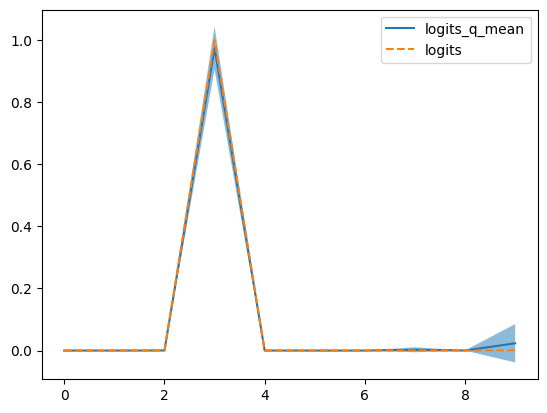

In [135]:
import copy
import qtorch
import qtorch.quant
import sys

sys.path.append('../')
from low_precision_utils import utils


number = qtorch.FloatingPoint(8, 0)
quantizer = qtorch.quant.Quantizer(number)

low_model = copy.deepcopy(model)
low_model = utils.replace_linear_with_quantized(low_model, number)

import matplotlib.pyplot as plt
def show(logits, logits_q):
    # fig = plt.figure()
    logits_q_mean = logits_q.mean(dim=0)
    logits_q_var = logits_q.std(dim=0)
    print(logits_q_mean.shape)
    # plot on fig
    
    plt.plot(logits_q_mean, label='logits_q_mean', linestyle='-')
    plt.plot(logits[0], label='logits', linestyle='--')
    # show the variance
    plt.fill_between(range(10), logits_q_mean - logits_q_var, logits_q_mean + logits_q_var, alpha=0.5)
    plt.legend()

book = []
for i, X in enumerate(train_data[7:]):
    logits, x = model.forward_x(X)
    X = X.repeat(100, 1)
    logits_q, x_q = low_model.forward_x(X)
    probs = torch.softmax(logits, dim=1)
    probs_q = torch.softmax(logits_q, dim=1)
    # logits_q = logits_q.mean(dim=0)
    # show(logits.detach().cpu(), logits_q.detach().cpu())
    show(probs.detach().cpu(), probs_q.detach().cpu())
    break

In [143]:
new_train_set = []
for i, X in enumerate(train_data):
    probs = torch.softmax(model(X), dim=1).detach()
    X = X.repeat(100, 1)
    probs_q = torch.softmax(low_model(X), dim=1).detach()
    probs_q_mean = probs_q.mean(dim=0)
    probs = probs.flatten()
    if probs_q_mean[9] > probs[9]:
        new_train_set.append(i)
    if i % 100 == 0:
        print(f'processed {i}')
    
    


processed 0
processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200
processed 1300
processed 1400
processed 1500
processed 1600
processed 1700
processed 1800
processed 1900
processed 2000
processed 2100
processed 2200
processed 2300
processed 2400
processed 2500
processed 2600
processed 2700
processed 2800
processed 2900
processed 3000
processed 3100
processed 3200
processed 3300
processed 3400
processed 3500
processed 3600
processed 3700
processed 3800
processed 3900
processed 4000
processed 4100
processed 4200
processed 4300
processed 4400
processed 4500
processed 4600
processed 4700
processed 4800
processed 4900
processed 5000
processed 5100
processed 5200
processed 5300
processed 5400
processed 5500
processed 5600
processed 5700
processed 5800
processed 5900
processed 6000
processed 6100
processed 6200
processed 6300
processed 6400
processed 6500
processed 6600
process

In [ ]:
# train the model

device = "cuda"

BATCH_SIZE = 128
model = MNIST_CNN().to(device)
train_data, train_labels, test_data, test_labels = loadMNISTData(device)

opt = torch.optim.SGD(model.parameters(), lr=0.1 / 8, momentum=0.9)

for e in range(10):
    for X, y in getBatches(train_data, train_labels):
        X = X.to(device)
        y = y.to(device)
        opt.zero_grad()
        result = model.loss_acc(X, y)
        result["loss"].backward()
        opt.step()
    print(f'epoch {e} loss: {result["loss"].item()} acc: {result["acc"]}')

In [56]:
logits

tensor([[ -3.6398,  -0.6201, -17.6399,   7.1925, -13.9207,  19.5216,   6.5537,
          -7.0063,   4.3796,   2.2164]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [57]:
x

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 53.2285,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 46.4949,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.5848,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [58]:
logits_q[2]

tensor([ -6.1601,   1.4751, -14.4640,  11.9486, -12.2046,  17.6362,   2.4248,
         -5.9208,   3.3800,   2.8658], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [63]:
logits_q_mean = logits_q.mean(dim=0)
logits_q_mean

tensor([ -4.8770,  -0.4094, -17.4009,   8.0247, -14.3730,  19.4944,   5.4122,
         -5.9416,   3.9182,   1.5186], device='cuda:0',
       grad_fn=<MeanBackward1>)

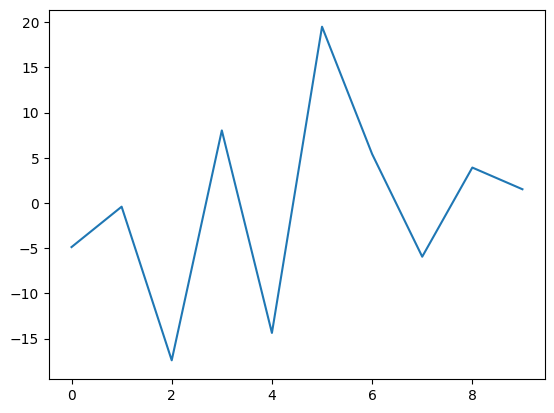

In [62]:
show(logits.detach().cpu(), logits_q_mean.detach().cpu())

In [86]:
ds

[(tensor([[  0.4219,  -5.9728,   6.5719,  18.6569, -19.7908,  22.8678,  -7.2065,
            -1.6701,  -2.1256,  -5.3263]]),
  tensor([[-1.4352,  0.8906,  0.1990,  2.4547, -6.3612,  4.8127, -0.2049, -3.3011,
           -0.6330,  0.5983]])),
 (tensor([[  0.4219,  -5.9728,   6.5719,  18.6569, -19.7908,  22.8678,  -7.2065,
            -1.6701,  -2.1256,  -5.3263]]),
  tensor([[ 2.5568,  7.6954, -2.1415, -6.4521, -0.4151, -0.0615,  4.3262,  6.1064,
           -4.9845, -8.3227]])),
 (tensor([[  0.4219,  -5.9728,   6.5719,  18.6569, -19.7908,  22.8678,  -7.2065,
            -1.6701,  -2.1256,  -5.3263]]),
  tensor([[ 1.1564,  0.6083,  1.1533,  0.9804, -4.2749,  1.2275, -2.1535, -0.1790,
           -7.7975,  1.5018]])),
 (tensor([[  0.4219,  -5.9728,   6.5719,  18.6569, -19.7908,  22.8678,  -7.2065,
            -1.6701,  -2.1256,  -5.3263]]),
  tensor([[-4.0142,  3.0547, -2.0328,  4.5670, -3.7353,  8.2055,  3.6667, -3.2980,
           -4.0458, -3.9037]])),
 (tensor([[  0.4219,  -5.9728,   6.5

ValueError: x and y can be no greater than 2D, but have shapes (10,) and (10, 1, 10)

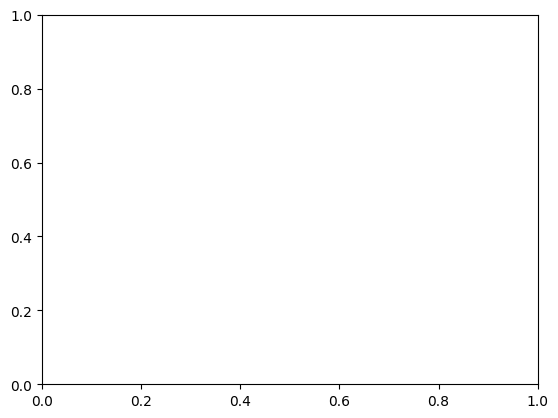

In [88]:

# 10 classes, plot the differences as the error bar

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
x = np.arange(10)
y = [d[0] for d in ds]
errors = [d[1] for d in ds]
ax.errorbar(x, y, yerr=errors, fmt='o')
plt.show()

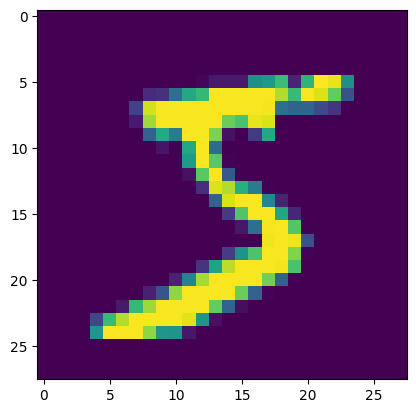

In [70]:
from matplotlib import pyplot as plt

plt.imshow(X.view(28, 28).cpu().numpy())